# 7. Analyzing Time-Series Data: website_date with ADF

## Containing:
#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Augmented Dickey-Fuller Test
#### 5. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
#### 6. Stationarizing the data

#### 1. Importing your libraries and data

In [151]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [152]:
# Define path

path = r'/Users/sophie/Desktop/CareerFoundry /10 2023 missing migrants'
path

'/Users/sophie/Desktop/CareerFoundry /10 2023 missing migrants'

In [153]:
df_mm = pd.read_pickle(os.path.join(path, 'Data', 'prepared data', 'df_mm.pkl'))
df_mm.head()

,main_ID,incident_ID,inc_type,region_inc,website_date_new,month_num,year,tot_dead_miss,tot_migrants,tot_survive,...,reg_origin,cause_death,country_origin,migration_route,loc_death,info_source,UNSD_geo_group,source_quality,inc_type_num,vict_per_incidents
0,2014.MMP00001,2014.MMP00001,Incident,North America,2014-01-06,1,2014,1,1,0,...,Central America,Mixed or unknown,Guatemala,US-Mexico border crossing,Pima Country Office of the Medical Examiner ju...,Pima County Office of the Medical Examiner (PC...,Northern America,5,1,1-4
1,2014.MMP00002,2014.MMP00002,Incident,North America,2014-01-12,1,2014,1,1,0,...,Latin America / Caribbean (P),Mixed or unknown,Unknown,US-Mexico border crossing,Pima Country Office of the Medical Examiner ju...,Pima County Office of the Medical Examiner (PC...,Northern America,5,1,1-4
2,2014.MMP00003,2014.MMP00003,Incident,North America,2014-01-14,1,2014,1,1,0,...,Latin America / Caribbean (P),Mixed or unknown,Unknown,US-Mexico border crossing,Pima Country Office of the Medical Examiner ju...,Pima County Office of the Medical Examiner (PC...,Northern America,5,1,1-4
3,2014.MMP00004,2014.MMP00004,Incident,North America,2014-01-16,1,2014,1,1,0,...,Central America,Violence,Mexico,US-Mexico border crossing,"near Douglas, Arizona, USA","Ministry of Foreign Affairs Mexico, Pima Count...",Northern America,5,1,1-4
4,2014.MMP00005,2014.MMP00005,Incident,Europe,2014-01-16,1,2014,1,3,2,...,Northern Africa,Harsh environmental conditions / lack of adequ...,Sudan,Unknown,Border between Russia and Estonia,EUBusiness (Agence France-Presse),Northern Europe,1,1,1-4


In [154]:
df_mm.shape

(13493, 24)

In [155]:
df_mm.columns

Index(['main_ID', 'incident_ID', 'inc_type', 'region_inc', 'website_date_new',
       'month_num', 'year', 'tot_dead_miss', 'tot_migrants', 'tot_survive',
       'identified_demogr', 'unidentified_demogr', 'latitude', 'longitude',
       'reg_origin', 'cause_death', 'country_origin', 'migration_route',
       'loc_death', 'info_source', 'UNSD_geo_group', 'source_quality',
       'inc_type_num', 'vict_per_incidents'],
      dtype='object')

In [156]:
type(df_mm)

pandas.core.frame.DataFrame

#### 2. Subsetting, wrangling, and cleaning time-series data

In [157]:
# Check for missing values

df_mm.isnull().sum()

# No missing values to handle

main_ID                0
incident_ID            0
inc_type               0
region_inc             0
website_date_new       0
month_num              0
year                   0
tot_dead_miss          0
tot_migrants           0
tot_survive            0
identified_demogr      0
unidentified_demogr    0
latitude               0
longitude              0
reg_origin             0
cause_death            0
country_origin         0
migration_route        0
loc_death              0
info_source            0
UNSD_geo_group         0
source_quality         0
inc_type_num           0
vict_per_incidents     0
dtype: int64

In [158]:
# Duplicates check

dups = df_mm.duplicated()
dups.shape # No dups

(13493,)

In [159]:
# Creating a subset for time-series analyses of variables of interest (total number of deads and missings and website dates)
# There are no irrelevant dates that have to be included, every incident since 2014 should be included in the analysis

sub_dates = df_mm[['website_date_new', 'tot_dead_miss']]

# Print the selected columns
print(sub_dates)

      website_date_new  tot_dead_miss
0           2014-01-06              1
1           2014-01-12              1
2           2014-01-14              1
3           2014-01-16              1
4           2014-01-16              1
...                ...            ...
13488       2023-10-11              1
13489       2023-10-13              7
13490       2023-10-12              2
13491       2023-10-01              1
13492       2023-10-17              1

[13493 rows x 2 columns]


In [160]:
# Set the "Date" column as the index

from datetime import datetime

sub_dates['datetime'] = pd.to_datetime(sub_dates['website_date_new']) # Create a datetime column from "website_date_new"
sub_dates = sub_dates.set_index('datetime') # Set the datetime as the index of the dataframe.
sub_dates.drop(['website_date_new'], axis=1, inplace=True) # Drop the "Date" column.
sub_dates.head()

,tot_dead_miss
datetime,
2014-01-06,1
2014-01-12,1
2014-01-14,1
2014-01-16,1
2014-01-16,1


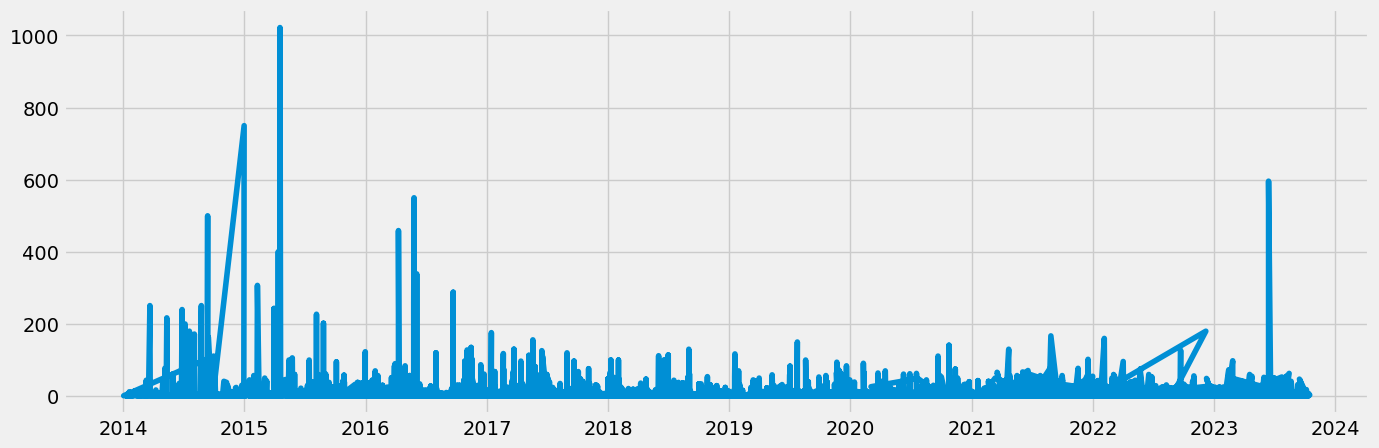

In [161]:
# Plot the new data set - create a line chart

plt.figure(figsize=(15,5), dpi=100)
plt.plot(sub_dates)

In [162]:
# Check for missing values (you shouldn't have any)

sub_dates.isnull().sum() 

tot_dead_miss    0
dtype: int64

In [163]:
# Check for duplicates

dups = sub_dates.duplicated()
dups.sum()

13356

In [164]:
duplicates = sub_dates[dups]
print(duplicates)

            tot_dead_miss
datetime                 
2014-01-12              1
2014-01-14              1
2014-01-16              1
2014-01-16              1
2014-01-17              1
...                   ...
2023-10-11              1
2023-10-13              7
2023-10-12              2
2023-10-01              1
2023-10-17              1

[13356 rows x 1 columns]


#### Data doesn't have a regular time interval (e.g., daily, hourly):
it's just a list of dates with different intervals between incidents, so using seasonal_decompose directly is not appropriate. This function is designed for time series data with a known and regular frequency.
In such cases, I need to use different time series analysis techniques that don't rely on a fixed frequency. One approach is to use rolling averages or moving averages to smooth out the data and identify trends or patterns.

In [165]:
#### Using website_date_new, the data will be very noisy.
#### In this case, you need to smooth the data before dickey_fuller test, such as

#data_smoothed = sub_dates.rolling(window=10).mean()

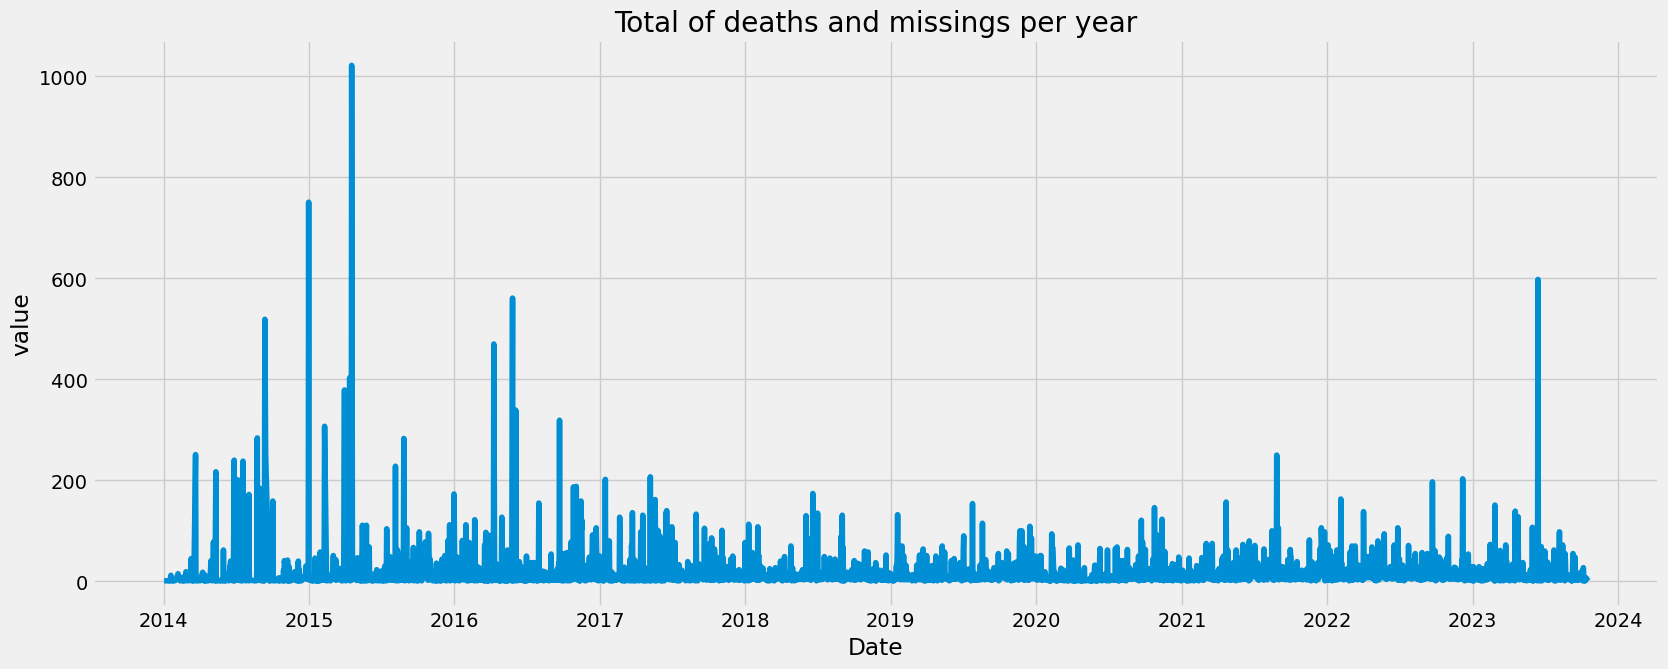

In [166]:
df2 = sub_dates.groupby('datetime').agg({'tot_dead_miss':['sum']})

plt.figure(figsize=(18,7), dpi=100) 
plt.title('Total of deaths and missings per year')
plt.xlabel('Date')
plt.ylabel('value')
plt.plot(df2)

### 3. Time series analysis: decomposition

In [167]:
# Decompose the time series using an additive model

#decomposition = sm.tsa.seasonal_decompose(df2, model='additive')

In [168]:
# After smoothing data, same error when trying to use the sm.tsa.seasonal_decompose function on the aggregated data, as the function still expects the data to have a regular frequency.
# Try alternative decomposition methods or analysis techniques that do not rely on a fixed frequency, such as the Singular Spectrum Analysis (SSA):

from statsmodels.tsa.filters.hp_filter import hpfilter

# Decompose the smoothed and aggregated data using the Hodrick-Prescott filter (HP filter)
trend, cycle = hpfilter(df2['tot_dead_miss'], lamb=1600)
df2['trend'] = trend
df2['cycle'] = cycle

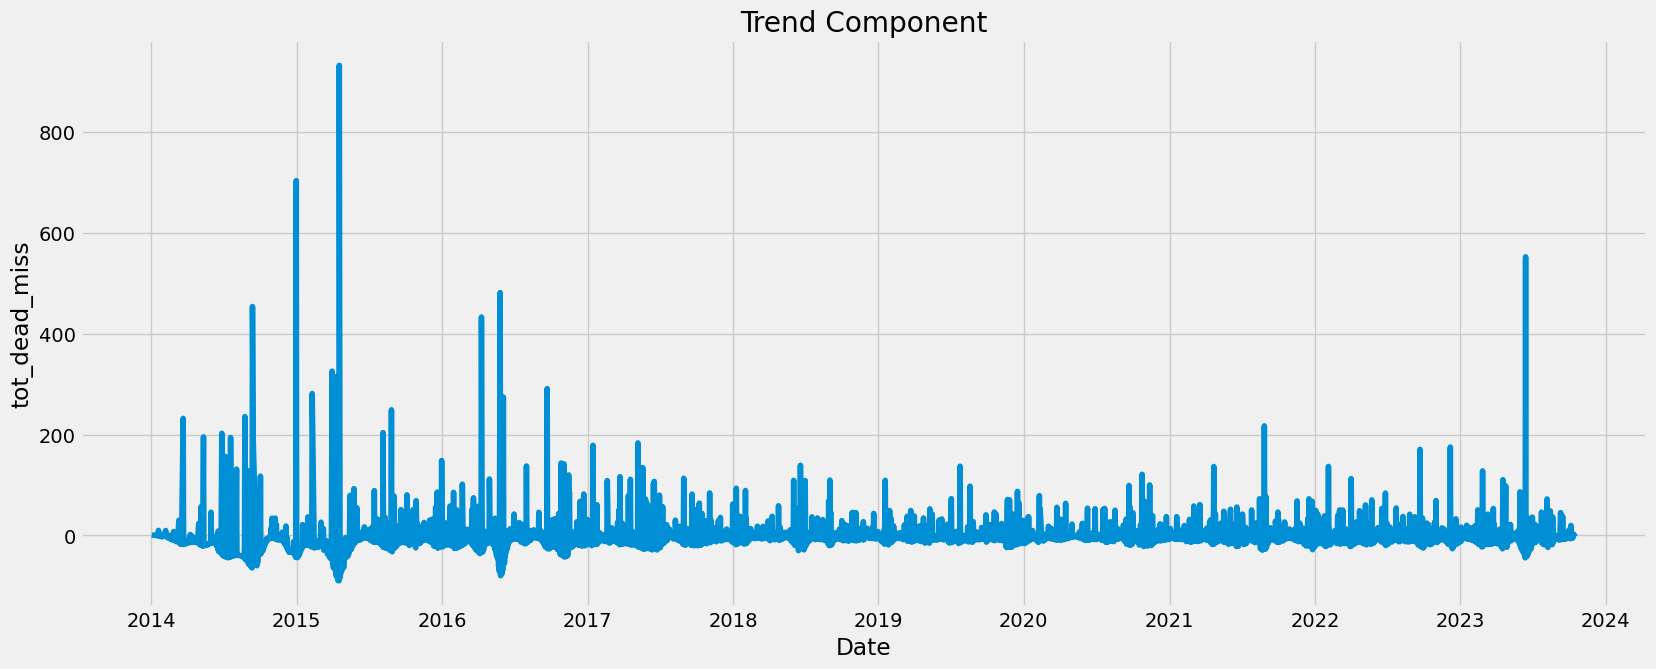

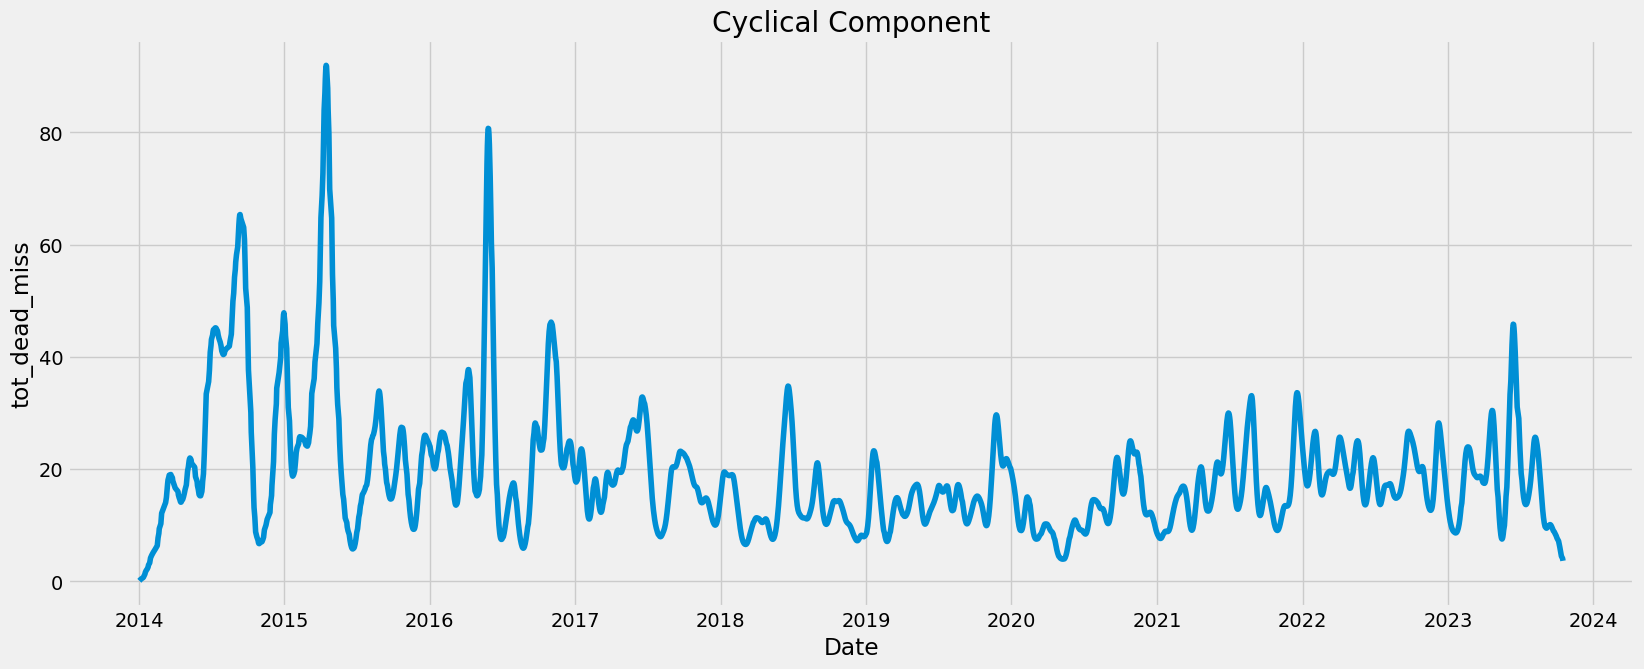

In [169]:
# Plot the trend component
plt.figure(figsize=(18, 7), dpi=100)
plt.title('Trend Component')
plt.xlabel('Date')
plt.ylabel('tot_dead_miss')
plt.plot(df2['trend'])

# Plot the cyclical component
plt.figure(figsize=(18, 7), dpi=100)
plt.title('Cyclical Component')
plt.xlabel('Date')
plt.ylabel('tot_dead_miss')
plt.plot(df2['cycle'])

#### Interpretation: no apparent trends (mean seams constant) or seasonality. However, data does not appear relatively constant over time (mainly in early years of recording). Standard deviation (volatility) is varying.

- we could perform local tests (testing mean, sd in small chunks)
- perform the augmented dickey-fuller test

https://www.youtube.com/watch?v=1opjnegd_hA
https://github.com/ritvikmath/Time-Series-Analysis/blob/master/Augmented%20Dickey-Fuller%20Test.ipynb

### 4. Augmented Dickey-Fuller Test

This test checks if data has a trend. If it does, it's not stationary. If the result of the test is less than a certain threshold (typically 0.05), then data is stationary.

In [172]:
# Import additional module

from statsmodels.tsa.stattools import adfuller

In [171]:
result = adfuller(df2)
if result[1] <= 0.05:
    print("Data is likely stationary.")
else:
    print("Data is likely not stationary.")

ValueError: x is required to have ndim 1 but has ndim 2

In [173]:
df2.head()

,tot_dead_miss,trend,cycle
,sum,,
datetime,,,
2014-01-02,1,0.904381,0.095619
2014-01-06,1,0.606825,0.393175
2014-01-12,1,0.308703,0.691297
2014-01-14,1,0.009071,0.990929
2014-01-16,2,0.706792,1.293208


In [174]:
df3 = df2[['tot_dead_miss']]

# Print the selected columns
print(df3)

           tot_dead_miss
                     sum
datetime                
2014-01-02             1
2014-01-06             1
2014-01-12             1
2014-01-14             1
2014-01-16             2
...                  ...
2023-10-11             1
2023-10-12             4
2023-10-13             7
2023-10-16             3
2023-10-17             1

[3188 rows x 1 columns]


In [175]:
result = adfuller(df3) # result = adfuller(df3['tot_dead_miss']) - without beforehand excluding columns
if result[1] <= 0.05:
    print("Data is likely stationary.")
else:
    print("Data is likely not stationary.")

Data is likely stationary.


In [176]:
def perform_adf_test(df3):
    result = adfuller(df3)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [177]:
perform_adf_test(df3)

ADF Statistic: -12.463424
p-value: 0.000000


#### Data is stationary.

### 5. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

This test looks for trends that are not constant. If the result is less than the critical value, data is stationary. If it's higher, data is not stationary.

In [178]:
from statsmodels.tsa.stattools import kpss

result = kpss(df3)
if result[1] <= 0.05:
    print("Data is likely not stationary.")
else:
    print("Data is likely stationary.")

Data is likely not stationary.


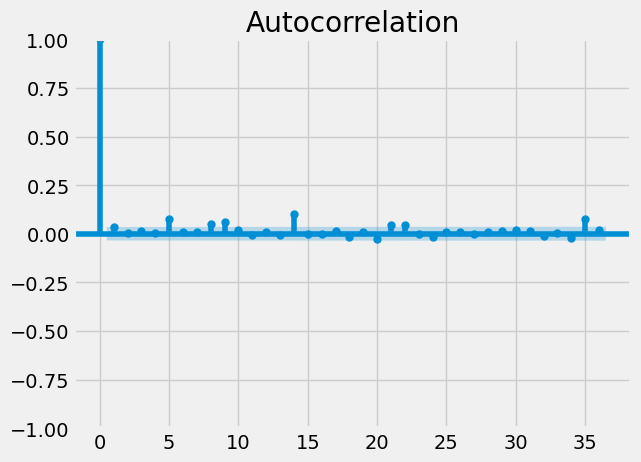

In [179]:
# Testing autocorrelation

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df3)
plt.show()

#### No substantial autocorrelation.

### 6. Stationarizing the data
via differencing

In [180]:
data_diff = df3 - df3.shift(1)

In [181]:
data_diff.dropna(inplace = True)

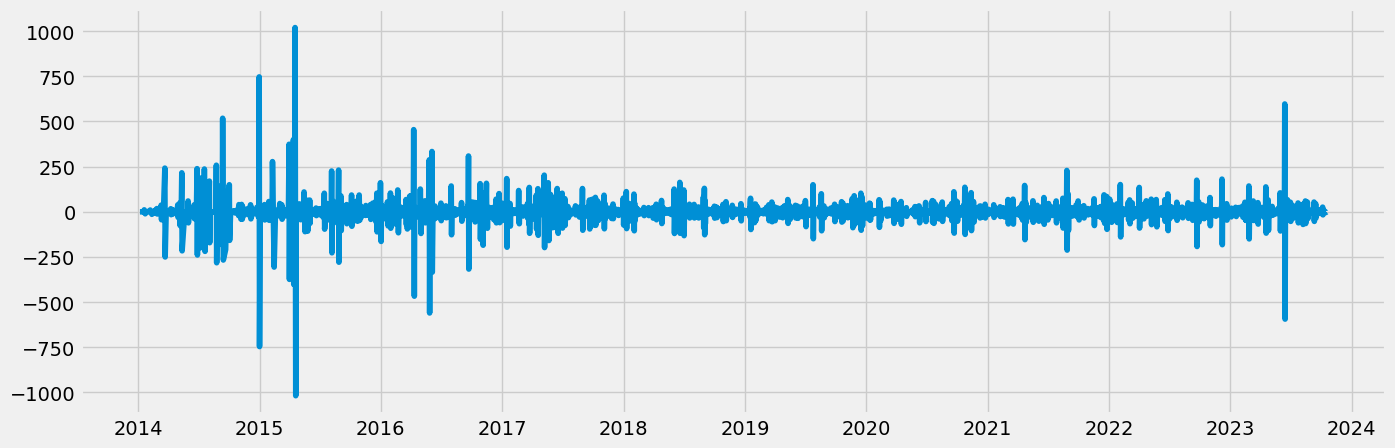

In [182]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [183]:
perform_adf_test(data_diff)

ADF Statistic: -17.168634
p-value: 0.000000


#### Data is stationary.

In [184]:
result = kpss(data_diff)
if result[1] <= 0.05:
    print("Data is likely not stationary.")
else:
    print("Data is likely stationary.")

Data is likely stationary.


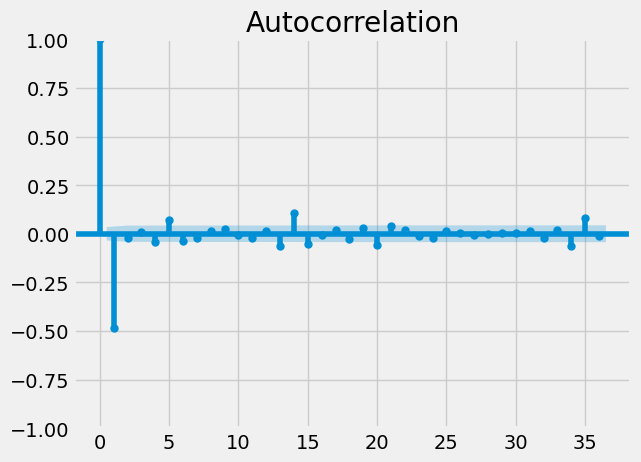

In [185]:
# Testing autocorrelation

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_diff)
plt.show()

#### Autocorrelation: <10 significant lags, but: autocorrelation increased after stationarizing.